The goal of this notebook is to create models that incorporate all columns. We want to see how the different models deal with this.

- The conclusion is that the RandomForestClassifier model holds up well against the neural network approach. It is, however, slightly worse than the neural network. 97.1% accuracy on the test set versus 98.0% accuracy For this reason, the in the next notebook (`n3`_text_to_vector), we will look into ways to improve the neural network by improving the word embedding of the `DescrizioneRiga` text column. 

In [1]:
import pandas as pd

# Load the Excel file
file_path = '../data/luiss_data_anonym.xlsx'
df = pd.read_excel(file_path)

In [2]:
# Delete all rows for which IvaM is missing because this is the value we want to predict
df = df[~df.IvaM.isna()]

# Calculate number of NaNs per column
nans_per_column = df.isnull().sum()

# Calculate percentage of NaNs per column
percentage_nans_per_column = (df.isnull().sum() / len(df)) * 100

# Display as dataframe
nans_df = pd.DataFrame({'Number of NaNs': nans_per_column, 'Percentage of NaNs': percentage_nans_per_column})

In [3]:
# Delete all columns with >5% missing values and impute all the missing data:

missing_percentage = df.isnull().sum() * 100 / len(df)
columns_to_drop = missing_percentage[missing_percentage > 5].index
df_cleaned = df.drop(columns=columns_to_drop)
df_cleaned = df_cleaned.drop(columns=["DataDoc"])

for column in ['B', 'D', 'Art1', 'Valore1', 'CMar', 'CTra', 'Rev', 'X']:
    df_cleaned[column] = df_cleaned[column].fillna(df_cleaned[column].mode()[0])

df_cleaned["DescrizioneRiga"] = df_cleaned["DescrizioneRiga"].fillna("")

In [4]:
# Check that fully inputed
nans_per_column = df_cleaned.isnull().sum()

# Calculate percentage of NaNs per column
percentage_nans_per_column = (df_cleaned.isnull().sum() / len(df_cleaned)) * 100

# Display as dataframe
nans_df = pd.DataFrame({'Number of NaNs': nans_per_column, 'Percentage of NaNs': percentage_nans_per_column})

# Feature creation

In [5]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from nltk.stem import WordNetLemmatizer
import re
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\20202034\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [6]:
def preprocess_features(df, nr_reduced_features=500):
    # Split the dataset into features and target variable
    X = df.drop('IvaM', axis=1)
    y = df[['IvaM']]

    # One hot encode target variable.
    encoder = OneHotEncoder()
    encoded_y = encoder.fit_transform(y[['IvaM']])
    encoded_y = encoded_y.toarray() 

    # Preprocess independent variables.
    # First one-hot encode the categorical columns by creating dummy columns
    categorical_features = X.select_dtypes(include=['object']).columns.tolist()
    categorical_features.remove("DescrizioneRiga")
    X[categorical_features] = X[categorical_features].astype(str)
    encoded_X = encoder.fit_transform(X[categorical_features])
    svd = TruncatedSVD(n_components=nr_reduced_features)
    X_reduced = svd.fit_transform(encoded_X)
    print(f"Explained variance ratio: {sum(svd.explained_variance_ratio_)}")
    # Numeric independent variables just have to be scaled
    numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
    scaler = StandardScaler()
    scaled_X = scaler.fit_transform(X[numeric_features])
    # Text column preprocessing
    def preprocess_text(text):
        text = str(text).lower()
        text = re.sub(r'\W', ' ', text)
        text = re.sub(r'\s+', ' ', text)
        lemmatizer = WordNetLemmatizer()
        words = text.split()
        words = [lemmatizer.lemmatize(word) for word in words]
        return ' '.join(words)
    text_transformer = TfidfVectorizer()
    text_features = 'DescrizioneRiga'
    X[text_features] = X[text_features].apply(preprocess_text)
    vectorized_text_X = text_transformer.fit_transform(X[text_features])
    # Summarizing the text vectors using SVD
    # For example, to reduce the data to 500 dimensions
    svd = TruncatedSVD(n_components=nr_reduced_features)
    X_reduced_text = svd.fit_transform(vectorized_text_X)
    print(f"Explained variance ratio: {sum(svd.explained_variance_ratio_)}")
    print(scaled_X.shape, encoded_X.shape, X_reduced.shape, vectorized_text_X.shape, X_reduced_text.shape)

    total_X = np.hstack((scaled_X, X_reduced, X_reduced_text))
    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(total_X, encoded_y, test_size=0.2, random_state=42)
    return X_train, X_test, y_train, y_test

# Train and evaluate NN

In [7]:
X_train, X_test, y_train, y_test = preprocess_features(df_cleaned)

Explained variance ratio: 0.8777511690528036
Explained variance ratio: 0.5158638014668682
(133966, 11) (133966, 44529) (133966, 500) (133966, 52013) (133966, 500)


Epoch 1/25
3350/3350 ━━━━━━━━━━━━━━━━━━━━ 35s 10ms/step - accuracy: 0.9139 - loss: 0.3622 - val_accuracy: 0.9751 - val_loss: 0.0809
Epoch 2/25
3350/3350 ━━━━━━━━━━━━━━━━━━━━ 52s 15ms/step - accuracy: 0.9730 - loss: 0.0877 - val_accuracy: 0.9791 - val_loss: 0.0675
Epoch 3/25
3350/3350 ━━━━━━━━━━━━━━━━━━━━ 59s 18ms/step - accuracy: 0.9789 - loss: 0.0631 - val_accuracy: 0.9860 - val_loss: 0.0428
Epoch 4/25
3350/3350 ━━━━━━━━━━━━━━━━━━━━ 57s 17ms/step - accuracy: 0.9817 - loss: 0.0526 - val_accuracy: 0.9849 - val_loss: 0.0409
Epoch 5/25
3350/3350 ━━━━━━━━━━━━━━━━━━━━ 65s 19ms/step - accuracy: 0.9833 - loss: 0.0465 - val_accuracy: 0.9888 - val_loss: 0.0321
Epoch 6/25
3350/3350 ━━━━━━━━━━━━━━━━━━━━ 51s 15ms/step - accuracy: 0.9854 - loss: 0.0413 - val_accuracy: 0.9883 - val_loss: 0.0342
Epoch 7/25
3350/3350 ━━━━━━━━━━━━━━━━━━━━ 44s 13ms/step - accuracy: 0.9864 - loss: 0.0396 - val_accuracy: 0.9901 - val_loss: 0.0278
Epoch 8/25
3350/3350 ━━━━━━━━━━━━━━━━━━━━ 51s 15ms/step - accuracy: 0.9866 -

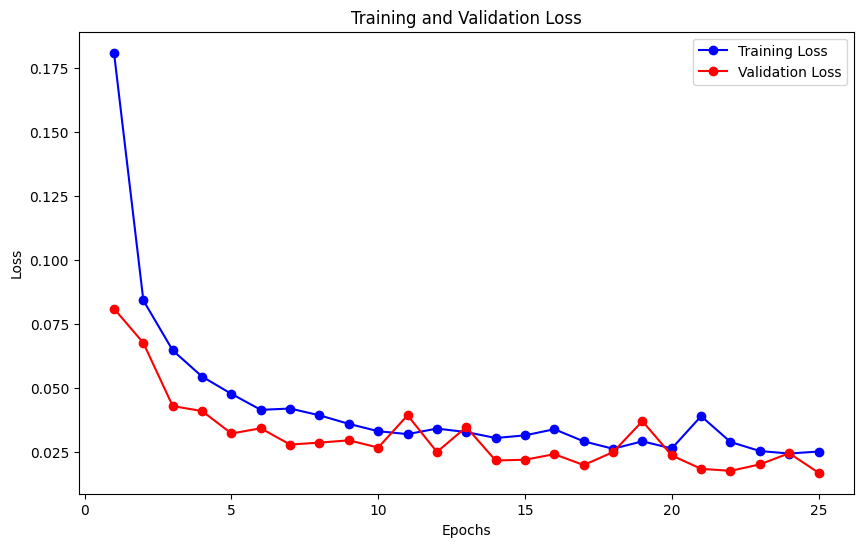

838/838 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.9803 - loss: 0.1722
Test Accuracy: 0.9802567958831787
Test Loss: 0.17508375644683838
838/838 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step


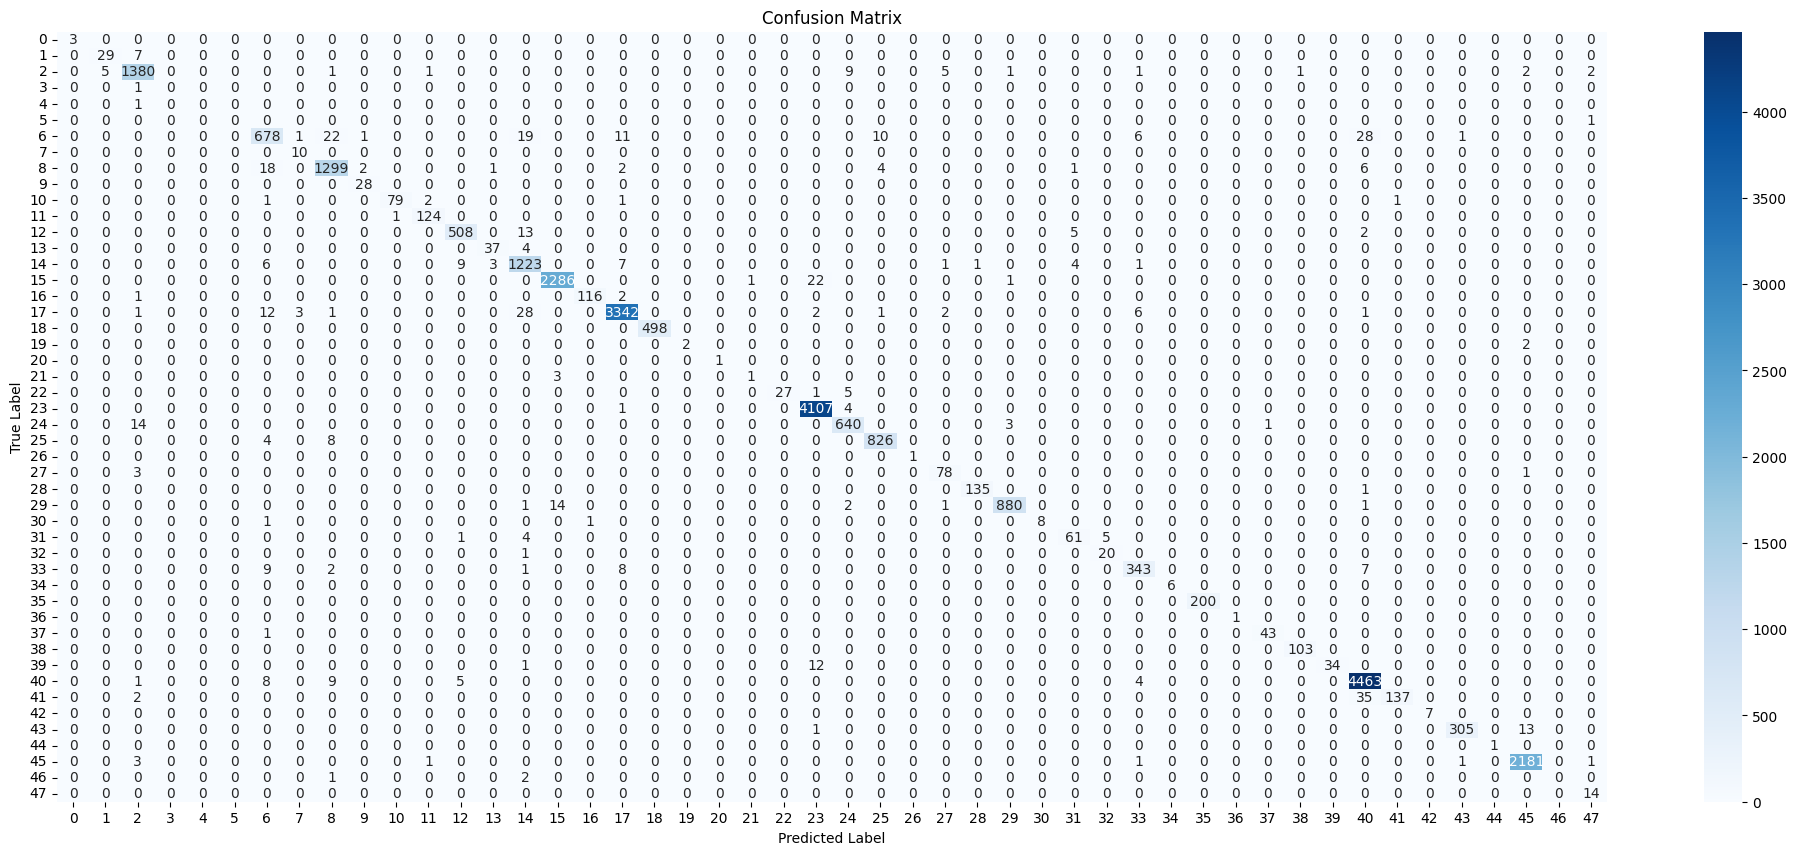

In [8]:
from tensorflow import keras
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

X_train_new, X_val, y_train_new, y_val = train_test_split(X_train, y_train, test_size=0.10, random_state=42)

model = keras.Sequential([
  keras.layers.Dense(units=512, activation="relu"),
  keras.layers.Dense(units=256, activation="relu"), 
  keras.layers.Dense(units=60, activation="softmax"),  # Output layer with softmax for 60 classes
])

model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

history = model.fit(X_train, y_train, epochs=25, batch_size=32, validation_data=(X_val, y_val))

train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(train_loss) + 1)

# Plot the training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_loss, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

test_loss, test_acc = model.evaluate(X_test, y_test)

print("Test Accuracy:", test_acc)
print("Test Loss:", test_loss)

y_pred = model.predict(X_test)

# The predictions are one-hot-encoded so change to label
y_pred2 = np.argmax(y_pred, axis=1)
y_test2 = np.argmax(y_test, axis=1)
conf_matrix = confusion_matrix(y_test2, y_pred2)

# Plot the confusion matrix
plt.figure(figsize=(25, 10))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [9]:
# Making predictions on the test set
test_predictions = model.predict(X_test)

y_pred2 = np.argmax(test_predictions, axis=1)
y_test2 = np.argmax(y_test, axis=1)

accuracy = accuracy_score(y_test2, y_pred2)
precision = precision_score(y_test2, y_pred2, average='macro')
recall = recall_score(y_test2, y_pred2, average='macro')
f1 = f1_score(y_test2, y_pred2, average='macro')

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-Score:", f1)

838/838 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step
Accuracy: 0.9802567739046055
Precision: 0.8691345584670703
Recall: 0.8494466170504799
F1-Score: 0.8545025639433487


c:\Users\20202034\OneDrive - TU Eindhoven\Documents\GitHub\BIP_ML_PROJECT_E00659\env_project\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


# Train and evaluate RF

In [10]:
# X_train, X_test, y_train, y_test = preprocess_features(df_cleaned)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.


building tree 1 of 24building tree 2 of 24
building tree 3 of 24
building tree 4 of 24
building tree 5 of 24

building tree 6 of 24
building tree 7 of 24
building tree 8 of 24
building tree 9 of 24
building tree 10 of 24
building tree 11 of 24
building tree 12 of 24
building tree 13 of 24
building tree 14 of 24
building tree 15 of 24
building tree 16 of 24
building tree 17 of 24
building tree 18 of 24
building tree 19 of 24
building tree 20 of 24
building tree 21 of 24
building tree 22 of 24
building tree 23 of 24
building tree 24 of 24


[Parallel(n_jobs=-1)]: Done  14 out of  24 | elapsed:  1.4min remaining:  1.0min
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:  1.7min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  14 out of  24 | elapsed:    0.9s remaining:    0.6s
[Parallel(n_jobs=12)]: Done  24 out of  24 | elapsed:    1.4s finished
c:\Users\20202034\OneDrive - TU Eindhoven\Documents\GitHub\BIP_ML_PROJECT_E00659\env_project\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\20202034\OneDrive - TU Eindhoven\Documents\GitHub\BIP_ML_PROJECT_E00659\env_project\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labe

Accuracy: 0.9745838620586699
Precision: 0.7154662639158446
Recall: 0.6598105990246775
F1-Score: 0.6829177661389271


[Parallel(n_jobs=12)]: Done  14 out of  24 | elapsed:    2.9s remaining:    2.0s
[Parallel(n_jobs=12)]: Done  24 out of  24 | elapsed:    3.4s finished


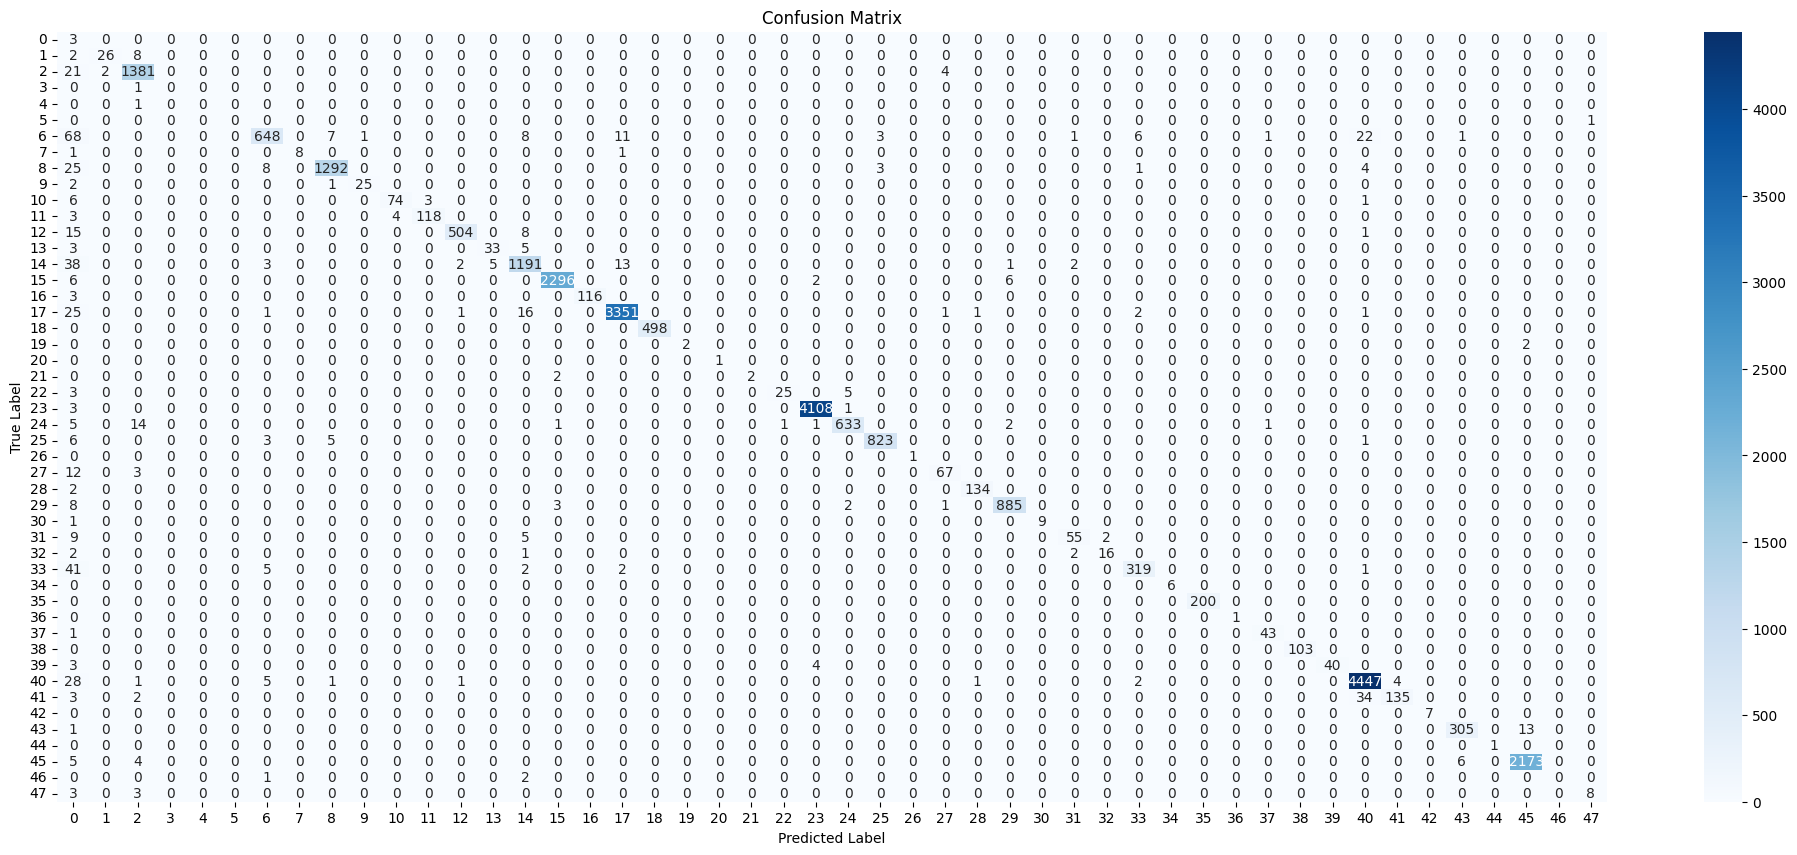

In [11]:
from sklearn.ensemble import RandomForestClassifier
import pickle

model_rf = RandomForestClassifier(verbose=2, n_estimators=24, n_jobs=-1, random_state=1)
model_rf.fit(X_train, y_train)

test_predictions = model_rf.predict(X_test)
accuracy = accuracy_score(y_test, test_predictions)
precision = precision_score(y_test, test_predictions, average='macro')
recall = recall_score(y_test, test_predictions, average='macro')
f1 = f1_score(y_test, test_predictions, average='macro')

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-Score:", f1)

test_predictions = model_rf.predict(X_test)

y_pred2 = np.argmax(test_predictions, axis=1)
y_test2 = np.argmax(y_test, axis=1)

conf_matrix = confusion_matrix(y_test2, y_pred2)

# Plotting the confusion matrix
plt.figure(figsize=(25, 10))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [12]:
# Save the model to disk using pickle
with open('../assets/full_rf_model_classif.pkl', 'wb') as file:
    pickle.dump(model_rf, file)